In [1]:
import sys, os
import numpy as np
import keras
import csv
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D

import matplotlib.pyplot as plt

from model import *

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8


get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


Using TensorFlow backend.


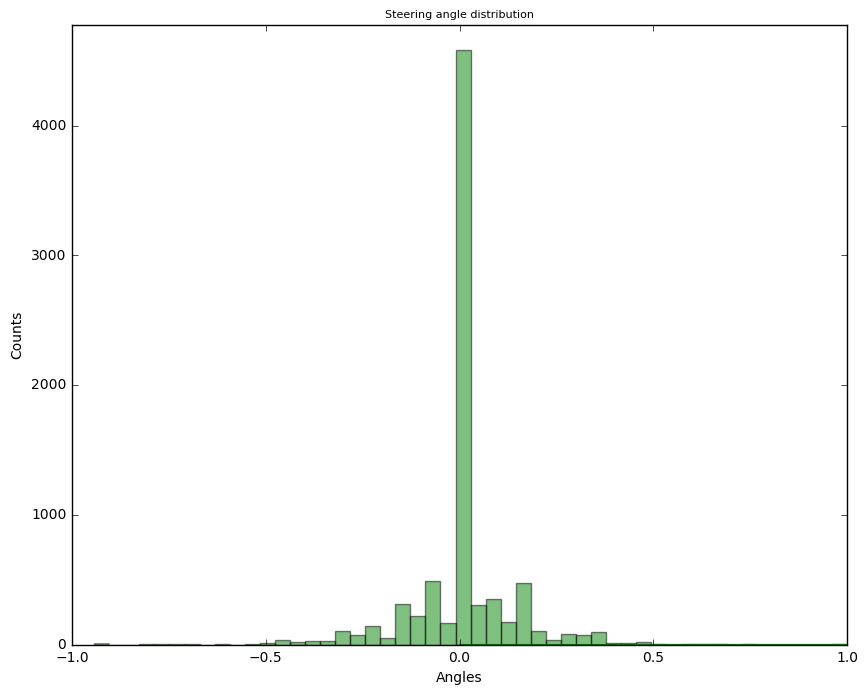

In [2]:
# Load the Udacity dataset. 
data_folder = "./data"
img_folder = "%s/IMG"%data_folder
steering_csv = "%s/driving_log.csv"%data_folder

steering = []
files = []

with open(steering_csv, 'r') as csvfile:
    rows = csv.reader(csvfile, delimiter=',')
    next(rows, None)
    for row in rows:
        steering.append(float(row[3]))
        files.append(["%s/%s"%(data_folder, row[i].strip()) for i in range(3)])

n, bins, _ = plt.hist(steering, 50, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, max(n)+200])

plt.show()

['./data/IMG/center_2016_12_01_13_39_00_989.jpg', './data/IMG/left_2016_12_01_13_39_00_989.jpg', './data/IMG/right_2016_12_01_13_39_00_989.jpg']


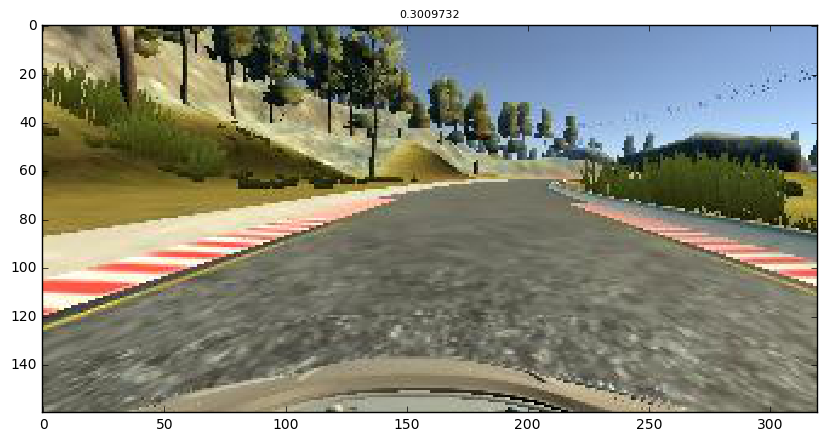

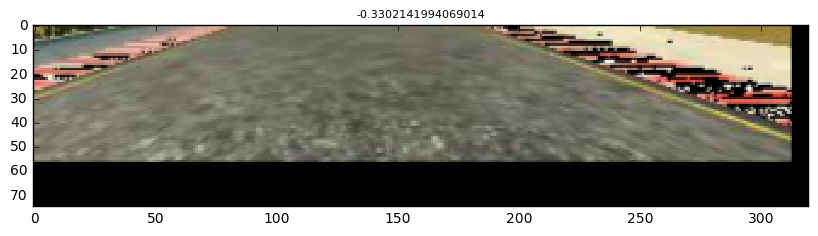

In [8]:
idx = np.random.randint(len(files))
img = cv2.imread(files[idx][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


print(files[idx])
plt.imshow(img)
plt.title(steering[idx])

# Translation
plt.figure()
X, y = prepare(img, steering[idx])
plt.imshow(X)
plt.title(y)
plt.show()

In [6]:
def plot_random_sample(idxs, cols=3, camera=0):
    rows = int(np.ceil(len(idxs)/float(cols)))
    for i, idx in enumerate(idxs):
        img = cv2.imread(files[idx][camera])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols,  i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("%.2f"%(steering[idx]))

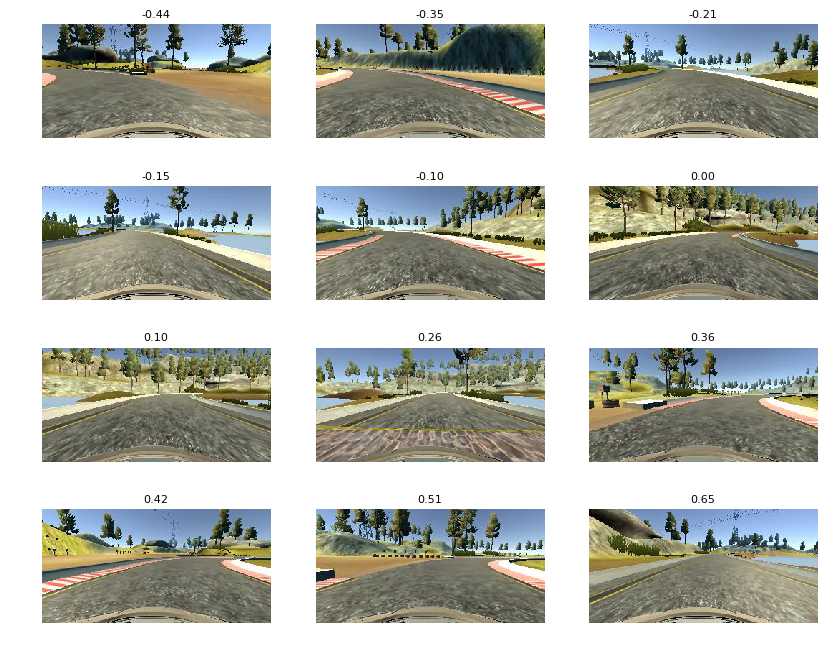

In [6]:
steering = np.array(steering)

angle = -0.5

subsample = []
for i in range(12):
    values = np.where(np.logical_and(steering >=angle, steering<(angle+0.1)))
    idxs = np.random.choice(values[0], 1)
    subsample.extend(idxs)
    angle = angle+0.1

plot_random_sample(subsample)

In [ ]:
# Exploring values within a certain range. 
idx = np.flatnonzero(steering < -0.5)
plot_random_sample(idx, 4)

In [9]:

N = len(files)
samples = np.random.choice(N, N, replace=False)
N_training = int(N * .90)

training_files = [files[samples[i]] for i in range(N_training)]
training_angles = [steering[samples[i]] for i in range(N_training)]

testing_files = [files[samples[i]] for i in range(N_training, N)]
testing_angles = [steering[samples[i]] for i in range(N_training, N)]

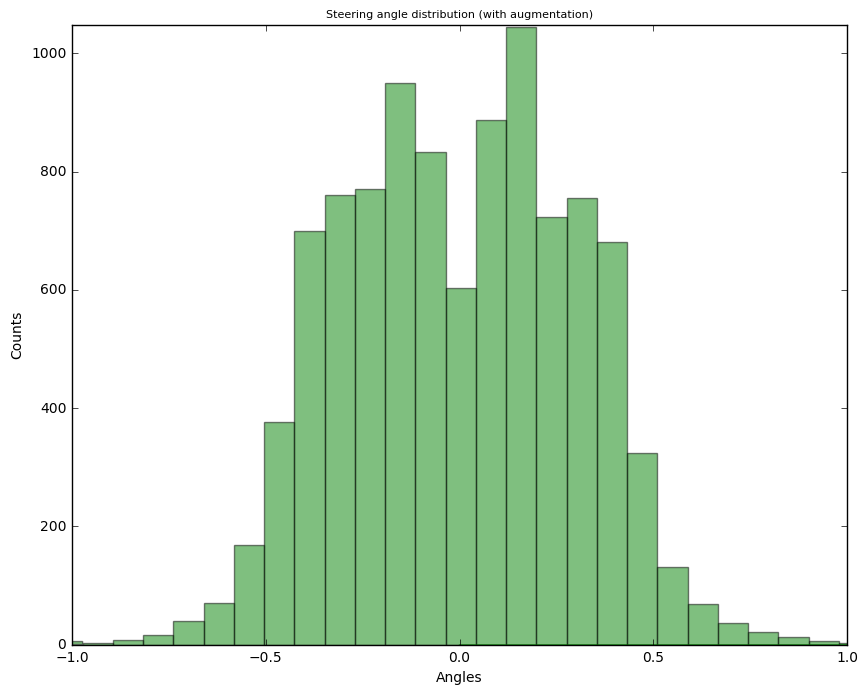

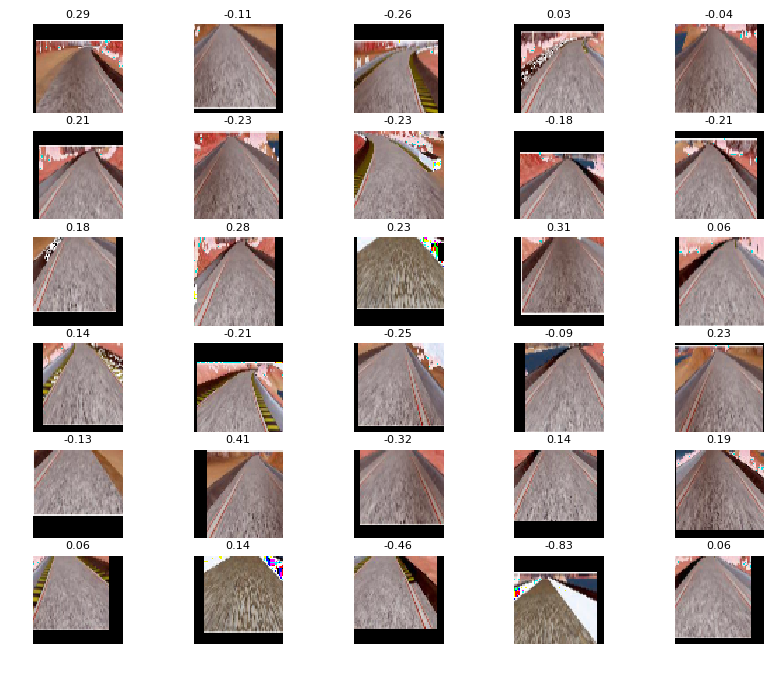

In [14]:
from model import *

train_X, train_y = next(training_generator(training_files, training_angles, 0.5, 10000))

n, bins, _ = plt.hist(train_y, 30, facecolor='green', alpha=0.5)
plt.plot(bins)
plt.title('Steering angle distribution (with augmentation)')
plt.xlabel('Angles')
plt.ylabel('Counts')
plt.axis([-1, 1, 0, max(n)+5])

plt.show()

plt.figure()
idxs = np.random.choice(train_X.shape[0], 30)
for i in range(len(idxs)):
    img = train_X[idxs[i]]
    plt.subplot(6, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%0.2f"%(train_y[idxs[i]]))
        

In [11]:
def getModel(key = "comma_ai"):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5,
                 input_shape = (row, col, ch)))
    
    if key == "comma_ai":
        model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(Flatten())
        model.add(Dropout(.2))
        model.add(ELU())
        model.add(Dense(512))
        model.add(Dropout((.5)))
        model.add(ELU())
        model.add(Dense(1))
    elif key == "nvidia":
        model.add(Convolution2D(3, 1, 1, subsample=(1, 1), activation="elu", border_mode="valid"))
        model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="elu", border_mode="valid"))
        model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="elu", border_mode="valid"))
        model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="elu", border_mode="valid"))
        model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation="elu", border_mode="valid"))
        model.add(Convolution2D(64, 3, 3, subsample=(1, 1), activation="elu", border_mode="valid"))
        model.add(Flatten())
        model.add(Dropout(.5))
        model.add(ELU())
        
        model.add(Dense(100))
        model.add(Dropout(.5))
        model.add(ELU())
        
        model.add(Dense(50))
        model.add(Dropout(.5))
        model.add(ELU())
        
        model.add(Dense(10))
        model.add(Dropout(.5))
        model.add(ELU())
        
        model.add(Dense(1))
        
    return model


In [12]:
row = 64
col = 64
ch = 3

model = getModel('nvidia')
model.compile(optimizer="adam", loss="mse")

EPOCHS = 10

cnt = 0
for i in range(EPOCHS):
    bias = 1. / (cnt + 1.)
    
    print (bias)
    history = model.fit_generator(
                    training_generator(training_files, training_angles, bias, 128), 
                    samples_per_epoch=20000, 
                    validation_data=validation_generator(testing_files, testing_angles, 128),
                    nb_val_samples=1000,
                    nb_epoch=1, 
                    verbose=2)
    cnt +=1
    
model.save("steering_model_nvidia.h5")
print ("Model saved")

1.0
Epoch 1/1


/home/faisal/anaconda3/envs/CarND-Term1/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


8s - loss: 0.0262 - val_loss: 0.0182
0.5
Epoch 1/1
8s - loss: 0.0219 - val_loss: 0.0212
0.3333333333333333
Epoch 1/1
8s - loss: 0.0219 - val_loss: 0.0282
0.25
Epoch 1/1
8s - loss: 0.0209 - val_loss: 0.0185
0.2
Epoch 1/1
8s - loss: 0.0243 - val_loss: 0.0226
0.16666666666666666
Epoch 1/1
8s - loss: 0.0272 - val_loss: 0.0183
0.14285714285714285
Epoch 1/1
8s - loss: 0.0221 - val_loss: 0.0398
0.125
Epoch 1/1
8s - loss: 0.0222 - val_loss: 0.0230
0.1111111111111111
Epoch 1/1
8s - loss: 0.0201 - val_loss: 0.0242
0.1
Epoch 1/1
8s - loss: 0.0217 - val_loss: 0.0532
Model saved


In [ ]:
if 'acc' in history.history:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

if 'loss' in history.history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

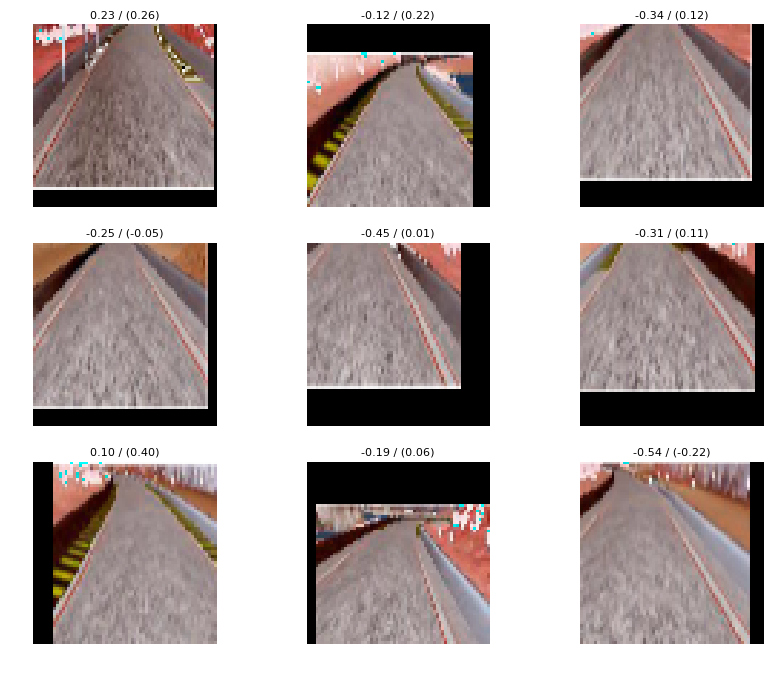

In [41]:
valid_X, valid_y = next(training_generator(training_files, training_angles, 0.5, 9))
pred_y = model.predict(valid_X)
for i in range(valid_X.shape[0]):
    img = valid_X[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%0.2f / (%0.2f)"%(valid_y[i], pred_y[i]))

[-0.3920597  -0.0787459   0.          0.04262284  0.0617599  -0.06925154
  0.         -0.05975719  0.         -0.1452064   0.05219137  0.          0.1670138
  0.0904655   0.          0.05219137  0.          0.          0.          0.0904655
  0.1861508  -0.135712    0.1765823  -0.05975719  0.2722676   0.1383082
 -0.0787459  -0.2971161  -0.3920597   0.02348577  0.          0.
 -0.04076847  0.         -0.1452064   0.1287396   0.          0.1765823
 -0.06925154  0.          0.1765823  -0.05975719  0.          0.          0.
  0.         -0.1641951   0.          0.          0.        ]
[[-0.08472341]
 [-0.16343349]
 [-0.02258818]
 [ 0.20187095]
 [ 0.03994224]
 [ 0.23041417]
 [-0.06506813]
 [ 0.05051394]
 [ 0.07221787]
 [-0.13317811]
 [ 0.17368153]
 [-0.16869816]
 [ 0.28196049]
 [ 0.0971123 ]
 [-0.23798276]
 [ 0.08899117]
 [ 0.17051417]
 [ 0.3188825 ]
 [ 0.14953242]
 [ 0.31637716]
 [ 0.11589637]
 [ 0.41926536]
 [-0.03462931]
 [-0.09446096]
 [ 0.10321397]
 [-0.04710134]
 [-0.25010693]
 [-0.0

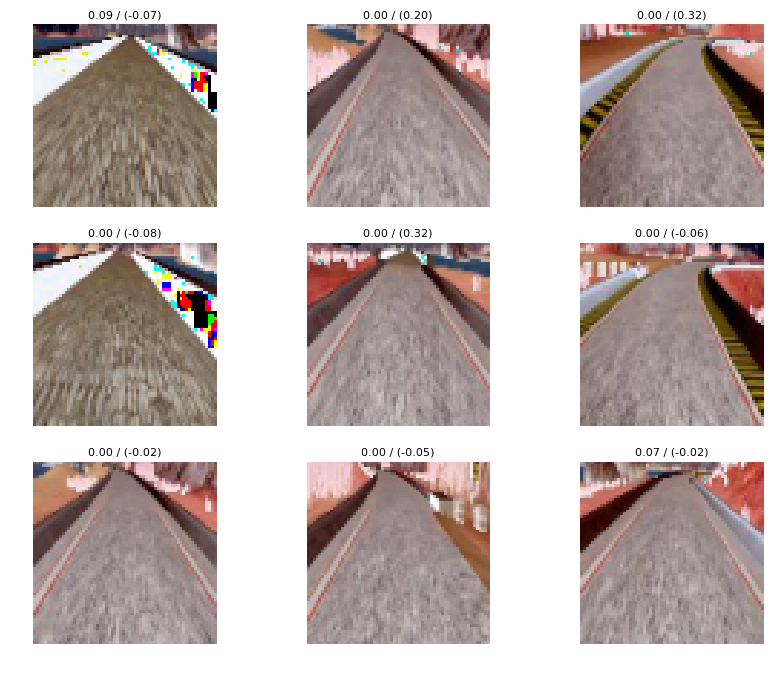

In [42]:
valid_X, valid_y = next(validation_generator(testing_files, testing_angles, 50))
pred_y = model.predict(valid_X)

print (valid_y)
print (pred_y)
#print (pred_y.reshape(-1))
#print (   ((valid_y - pred_y.reshape(-1)) ** 2).mean() )

valid_X, valid_y = next(validation_generator(testing_files, testing_angles, 9))
pred_y = model.predict(valid_X)
for i in range(valid_X.shape[0]):
    img = valid_X[i]
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("%0.2f / (%0.2f)"%(valid_y[i], pred_y[i]))